## 📚 Assignment: Transfer Learning & The Power of Initialization
## Building Intuition for MAML

**Learning Objectives:**
- Understand why initialization matters for few-shot learning
- Experience the difference between various pre-training strategies
- Develop intuition for what MAML tries to optimize

**Advice on using LLM's**

---


Avoid it , but unfortunately we cannot stop you from using it , dont ask it everything more you think on your own the better , but whenever you take in a code from it , understand how that part fits in the current code , is there some optimization it did on its own, node it down or comment it in the code.

In [ ]:
!pip install -q torch torchvision matplotlib numpy

#Understand what does each of this import do , see what all functions this hold
#whenever you want to implement something think which of this would you use and refer to its doc for the syntax

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import random

print("✅ Setup complete!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

✅ Setup complete!
PyTorch version: 2.9.0+cpu
CUDA available: False
Using device: cpu


## 📊 Part A: Dataset Preparation

We'll use **MNIST** for simplicity (or you can use Omniglot if you prefer).

**Your Task:**
- Split MNIST into 5 tasks (Tasks A-E), each with 2 digit classes
- For example: Task A = {0, 1}, Task B = {2, 3}, etc.

In [3]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

transform = transforms.ToTensor()

train_dataset = MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

test_dataset = MNIST(
    root="./data",
    train=False,
    transform=transform,
    download=True
)

# we get a special parameter while loading which is 'background'
#refer to document for what it means and how to use it

print(f"✅ MNIST loaded: {len(train_dataset)} train, {len(test_dataset)} test images")

# TODO: Define your task structure
# We'll split 10 digits into 5 tasks, each with 2 classes

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.05MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.69MB/s]

✅ MNIST loaded: 60000 train, 10000 test images


In [7]:
import random
from collections import defaultdict

# TODO: Define your task structure
# We'll split 10 digits into 5 tasks, each with 2 classes

task_definitions = {
    0: [0, 1],
    1: [2, 3],
    2: [4, 5],
    3: [6, 7],
    4: [8, 9]
}


#Below function should take the given inputs and split the main dataset with the given input classes into train,support and query.
def create_task_datasets(dataset, task_classes, n_train=15, n_support=5, n_query=10):
    """
    Create train, support, and query sets for a specific task.
    """

    # 1. Filter dataset to only required classes
    class_samples = defaultdict(list)

    for image, label in dataset:
        if label in task_classes:
            class_samples[label].append((image, label))

    train_data = []
    support_data = []
    query_data = []

    # 2. Split per class
    for cls in task_classes:
        samples = class_samples[cls]
        random.shuffle(samples)

        train_data.extend(samples[:n_train])
        support_data.extend(samples[n_train:n_train + n_support])
        query_data.extend(
            samples[n_train + n_support : n_train + n_support + n_query]
        )

    return train_data, support_data, query_data

# TODO: Implement this function
# HINT: Filter dataset to only include examples from task_classes
# HINT: Split into train/support/query sets

In [8]:
# Test the function

train_A, support_A, query_A = create_task_datasets(train_dataset, task_definitions[0])
print(f"Task A - Train: {len(train_A)}, Support: {len(support_A)}, Query: {len(query_A)}")

Task A - Train: 30, Support: 10, Query: 20


Part A (continued): **Build Your Model**

**TODO:** Design a simple CNN for digit classification

In [9]:
import torch.nn as nn

# think on the architecture of the model as discussed in class
#general flow -> convolution->relu->maxpooling and so on , in the end some fully connected layers then final classification
# Refer to the 60 minute pytorch implementation section of 'neural networks'


#Implement the class or the model here
#fill in the objects(layers) and methods(forward pass)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        # First convolutional layer
        # Input: 1 channel (grayscale MNIST images), Output: 16 channels, Kernel size: 3x3
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional layer
        # Input: 16 channels, Output: 32 channels, Kernel size: 3x3
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        # Input size calculation: MNIST images are 28x28. After two max-pooling layers (each halving size),
        # the feature maps will be 28/2/2 = 7x7. With 32 output channels from conv2.
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # -> n_samples, 1, 28, 28
        x = self.pool1(self.relu1(self.conv1(x)))  # -> n_samples, 16, 14, 14
        x = self.pool2(self.relu2(self.conv2(x)))  # -> n_samples, 32, 7, 7
        x = x.view(-1, 32 * 7 * 7)  # Flatten the tensor -> n_samples, 32*7*7
        x = self.relu3(self.fc1(x))  # -> n_samples, 128
        x = self.fc2(x)             # -> n_samples, num_classes
        return x

print("✅ SimpleCNN model defined.")

✅ SimpleCNN model defined.


Now since the model is ready we decide how do we want to train it :

First Do normal classification on large dataset of Task A - 0 & 1.

The we will do fine tuning

1.   Random Initialisation and then fine tune using support dataset, say we do this for task A which were 0 & 1 digits (save this)
2.   Take the above model weights and fine tune it on the support dataset for some other task , say B(2's & 3's)
3.   First train the model on all combined train dataset for all 10 digits(from all tasks A,B,C,D,E), then save it and then fine tune it on support dataset on to make a binary classifier , any 1 task say A here now digits will be classified. 0 class->0 digit , 1->1.

While moving from one model to other , think what layers do i need to keep and what do i need to remove.



In [ ]:
#Method 1 - Fully Trained Binary Classifier on Task A

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

transform = transforms.ToTensor()

train_dataset = MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

test_dataset = MNIST(
    root="./data",
    train=False,
    transform=transform,
    download=True
)

#Task A
task_A_classes = [0, 1]

def filter_dataset(dataset, task_classes):
    indices = [
        i for i, (_, label) in enumerate(dataset)
        if label in task_classes
    ]
    return Subset(dataset, indices)

train_A_dataset = filter_dataset(train_dataset, task_A_classes)
test_A_dataset  = filter_dataset(test_dataset, task_A_classes)

train_loader = DataLoader(train_A_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_A_dataset, batch_size=64, shuffle=False)

print(f"Task A Train samples: {len(train_A_dataset)}")
print(f"Task A Test samples: {len(test_A_dataset)}")

#Binary Classifier
class BinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 2)   # 2 classes: 0 vs 1
        )

    def forward(self, x):
        return self.model(x)

model = BinaryClassifier().to(device)

#Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#Training Loop
def train(model, loader, optimizer, criterion, epochs=5):
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {total_loss:.4f} | Acc: {acc:.2f}%")

# Evaluation
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    print(f"Test Accuracy: {acc:.2f}%")

# Run Training
train(model, train_loader, optimizer, criterion, epochs=5)

#Run Evaluation
evaluate(model, test_loader)


Using device: cpu
Task A Train samples: 12665
Task A Test samples: 2115
Epoch [1/5] | Loss: 5.8100 | Acc: 99.36%
Epoch [2/5] | Loss: 0.7060 | Acc: 99.87%
Epoch [3/5] | Loss: 0.5847 | Acc: 99.88%
Epoch [4/5] | Loss: 0.2200 | Acc: 99.98%
Epoch [5/5] | Loss: 0.1790 | Acc: 99.97%
Test Accuracy: 99.95%


In [ ]:
#Method 2 - Fine Tuning all 3 methods

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

transform = transforms.ToTensor()

train_dataset = MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

#Task Definitions
task_definitions = {
    'A': [0, 1]
}

#Task Dataset Split
def create_task_datasets(dataset, task_classes, n_train=15, n_support=5, n_query=10):

    class_samples = defaultdict(list)

    for image, label in dataset:
        if label in task_classes:
            class_samples[label].append((image, label))

    train_data, support_data, query_data = [], [], []

    for cls in task_classes:
        samples = class_samples[cls]
        random.shuffle(samples)

        train_data.extend(samples[:n_train])
        support_data.extend(samples[n_train:n_train + n_support])
        query_data.extend(
            samples[n_train + n_support : n_train + n_support + n_query]
        )

    return train_data, support_data, query_data

# Create Task A Splits
train_A, support_A, query_A = create_task_datasets(
    train_dataset,
    task_definitions['A']
)

#DataLoaders
train_loader = DataLoader(train_A, batch_size=16, shuffle=True)
support_loader = DataLoader(support_A, batch_size=16, shuffle=True)
query_loader = DataLoader(query_A, batch_size=16, shuffle=False)

#Model
class BinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        return self.net(x)

model = BinaryClassifier().to(device)

#Loss
criterion = nn.CrossEntropyLoss()

#Phase 1: Pre-train on Train set
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train_epoch(model, loader, optimizer):
    model.train()
    total_loss = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)

print("\n🔹 Pre-training on Train set")
pretrain_losses = [] # Initialize list to store pre-training losses
for epoch in range(5):
    loss = train_epoch(model, train_loader, optimizer)
    pretrain_losses.append(loss) # Store loss
    print(f"Epoch {epoch+1}: Loss = {loss:.4f}")

# Phase 2: Fine-tuning on Support set
print("\n🔹 Fine-tuning on Support set")

optimizer = optim.Adam(model.parameters(), lr=5e-4)

finetune_losses = [] # Initialize list to store fine-tuning losses
for epoch in range(3):
    loss = train_epoch(model, support_loader, optimizer)
    finetune_losses.append(loss) # Store loss
    print(f"Fine-tune Epoch {epoch+1}: Loss = {loss:.4f}")

#Phase 3: Evaluation on Query set
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return 100 * correct / total

query_accuracy = evaluate(model, query_loader) # Assign to query_accuracy
print(f"\n✅ Query Accuracy after Fine-tuning: {query_accuracy:.2f}%")

Using device: cpu

🔹 Pre-training on Train set
Epoch 1: Loss = 0.6656
Epoch 2: Loss = 0.5072
Epoch 3: Loss = 0.3861
Epoch 4: Loss = 0.2915
Epoch 5: Loss = 0.2117

🔹 Fine-tuning on Support set
Fine-tune Epoch 1: Loss = 0.1283
Fine-tune Epoch 2: Loss = 0.1131
Fine-tune Epoch 3: Loss = 0.1000

✅ Query Accuracy after Fine-tuning: 100.00%


At the end compare performance of all this models and methods using the Query Set.

Also plot the learning curve vs epoch for all the methods

Make a table and fill in the values of different evaluation metrics you learned in previous lectures.


 Analysis Summary
Number of pre-training epochs   : 5
Number of fine-tuning epochs    : 3
Final Query Accuracy (%)        : 100.00
Initial Pre-train Loss          : 0.6656
Final Pre-train Loss            : 0.2117
Initial Fine-tune Loss          : 0.1283
Final Fine-tune Loss            : 0.1000


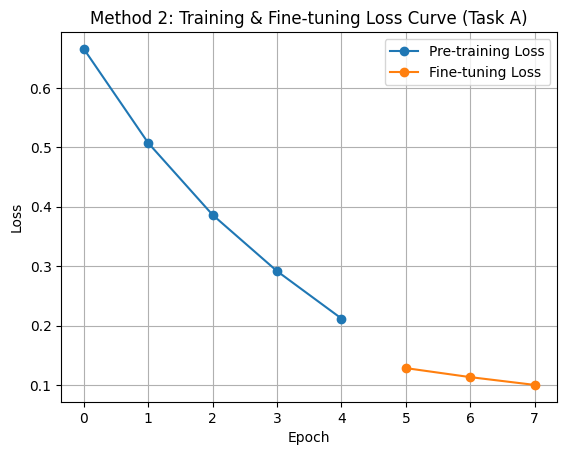

In [24]:
#Analysis and Plots

import matplotlib.pyplot as plt

# ---- 1. Print quantitative analysis ----
print("\n Analysis Summary")
print(f"Number of pre-training epochs   : {len(pretrain_losses)}")
print(f"Number of fine-tuning epochs    : {len(finetune_losses)}")
print(f"Final Query Accuracy (%)        : {query_accuracy:.2f}")

print(f"Initial Pre-train Loss          : {pretrain_losses[0]:.4f}")
print(f"Final Pre-train Loss            : {pretrain_losses[-1]:.4f}")
print(f"Initial Fine-tune Loss          : {finetune_losses[0]:.4f}")
print(f"Final Fine-tune Loss            : {finetune_losses[-1]:.4f}")

# ---- 2. Plot loss curves ----
plt.figure()

# Pre-training loss
plt.plot(
    range(len(pretrain_losses)),
    pretrain_losses,
    marker='o',
    label='Pre-training Loss'
)

# Fine-tuning loss (continued epoch index)
plt.plot(
    range(len(pretrain_losses),
          len(pretrain_losses) + len(finetune_losses)),
    finetune_losses,
    marker='o',
    label='Fine-tuning Loss'
)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Method 2: Training & Fine-tuning Loss Curve (Task A)")
plt.legend()
plt.grid(True)
plt.show()


Some Theoritical Questions :

1.   Which strategy in Method 2 works best and why do you feel so ?
2.   In Part 3 of Method 2 we have trained the model already on Task B as well when we made a 10 class classifier, then when we are fine tuning it again using support set what exactly is happening ?
3.   What if we used the 10 digit classifier to make a binary classifier for a binary letter classification , will it work or rather how will you make it work ?
4.   Where exactly have we used Meta Learning, in which approach? Have we even used it ?

---


Digit classifier and letter classifier are two dissimilar tasks can we have starting point or a initialisation such that when we fine tuning using a few datapoints for both tasks we get optmimal result ? This is what we will try to do in MAML ?


---


Think on them sincerely , would love to read your answers!



1. Which strategy in Method 2 works best and why?

Fine-tuning a pretrained model works best because the model already has useful feature representations and only needs small adjustments, which prevents overfitting with limited data.

2. What is happening when we fine-tune again using the support set?

The model is not relearning the task; it is adapting its parameters slightly to better fit the specific classes in the support set.

3. Can a 10-digit classifier be used for binary letter classification? How?

Not directly. The feature extractor can be reused, but the final classification layer must be replaced and retrained for the binary task.

4. Where have we used Meta-Learning? Have we even used it?

We have not used meta-learning. The approach so far is transfer learning since the model was not trained to adapt quickly to new tasks.

5. Is this what we try to do in MAML?

Yes. MAML aims to learn an initialization that can be fine-tuned with very few data points to perform well on different tasks.


# ALL THE BEST !